# SVD demo on UCI Optical Recognition of Handwritten Digits



In [1]:
# 0. Setup: imports and plotting config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

# scikit-learn imports
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

%matplotlib inline

print('Ready — run the following cells to download and run the demo.')

Ready — run the following cells to download and run the demo.


In [2]:
# 1. Download the dataset (if not already present)
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra'
test_url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes'

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)
train_path = data_dir / 'optdigits.tra'
test_path  = data_dir / 'optdigits.tes'

for url, p in [(train_url, train_path), (test_url, test_path)]:
    if not p.exists():
        print(f'Downloading {url} -> {p} ...')
        urlretrieve(url, str(p))
    else:
        print(f'Already downloaded: {p}')

print('\nFiles:')
print(train_path, test_path)



Files:
data/optdigits.tra data/optdigits.tes


In [3]:
# 2. Load the data into pandas / numpy
cols = list(range(65))  # 64 features + 1 label
train = pd.read_csv('data/optdigits.tra', header=None)
test  = pd.read_csv('data/optdigits.tes', header=None)

print('train shape:', train.shape)
print('test  shape:', test.shape)

X_train = train.iloc[:, :64].astype(float).values
y_train = train.iloc[:, 64].astype(int).values

X_test = test.iloc[:, :64].astype(float).values
y_test = test.iloc[:, 64].astype(int).values

print('\nExample label distribution (train):')
print(pd.Series(y_train).value_counts().sort_index())


train shape: (3823, 65)
test  shape: (1797, 65)

Example label distribution (train):
0    376
1    389
2    380
3    389
4    387
5    376
6    377
7    387
8    380
9    382
Name: count, dtype: int64


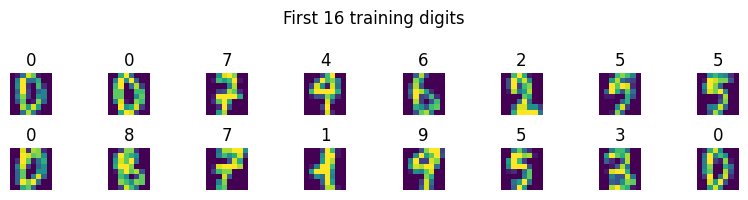

In [4]:
# Helper: display a grid of digits
import math

def plot_digits(X, labels=None, n_cols=8, title=None):
    n = X.shape[0]
    n_cols = min(n_cols, n)
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    axes = np.array(axes).reshape(-1)
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i < n:
            ax.imshow(X[i].reshape(8,8), interpolation='nearest')
            if labels is not None:
                ax.set_title(str(labels[i]))
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_digits(X_train[:16], labels=y_train[:16], n_cols=8, title='First 16 training digits')


Shapes: U (3823, 64) S (64,) Vt (64, 64)
First 10 singular values (scikit-learn randomized_svd): [828.08129518 786.1472062  733.34158646 622.27383007 510.1133737
 484.11539628 463.11031183 413.92468168 399.51584232 379.8462069 ]


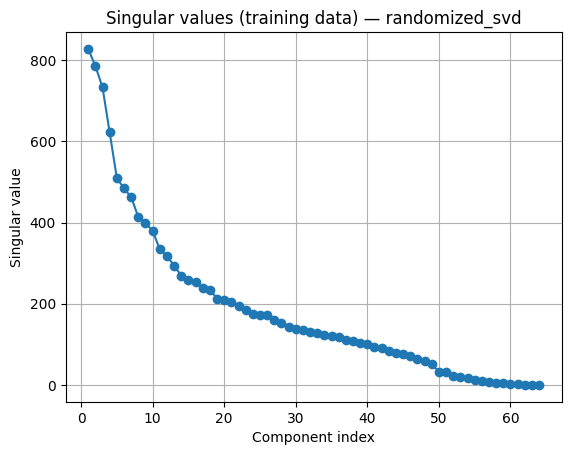

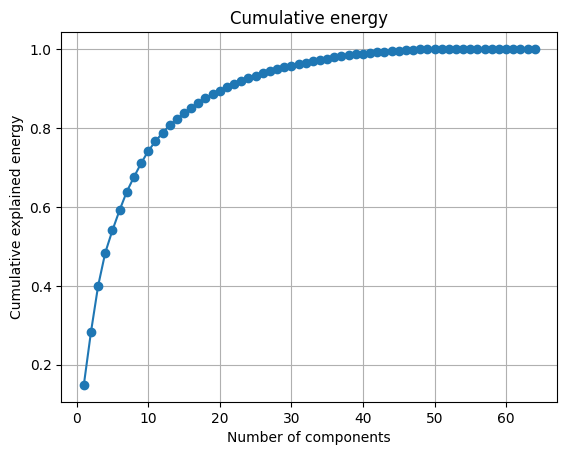

Components for 90% energy: 21
Components for 95% energy: 29
Components for 99% energy: 41


In [5]:
# 3. Compute SVD using scikit-learn's randomized_svd
# We'll center the data (feature-wise) and run randomized_svd to get U, S, Vt
X = X_train.copy()
X_mean = X.mean(axis=0)
Xc = X - X_mean

# randomized_svd to compute all 64 singular values (approximate, fast)
# n_components=64 (full for this dataset), n_iter=5 for accuracy
U_r, S_r, Vt_r = randomized_svd(Xc, n_components=64, n_iter=5, random_state=42)
print('Shapes: U', U_r.shape, 'S', S_r.shape, 'Vt', Vt_r.shape)

# singular values and cumulative energy
print('First 10 singular values (scikit-learn randomized_svd):', S_r[:10])
energy = S_r**2
cum_energy = np.cumsum(energy) / np.sum(energy)

plt.figure()
plt.plot(np.arange(1, len(S_r)+1), S_r, marker='o')
plt.xlabel('Component index')
plt.ylabel('Singular value')
plt.title('Singular values (training data) — randomized_svd')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.arange(1, len(S_r)+1), cum_energy, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained energy')
plt.title('Cumulative energy')
plt.grid(True)
plt.show()

for thr in [0.90, 0.95, 0.99]:
    k = np.searchsorted(cum_energy, thr) + 1
    print(f'Components for {int(thr*100)}% energy: {k}')



Reconstruction with k = 1


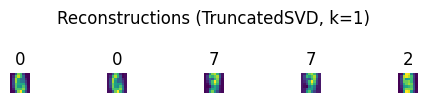


Reconstruction with k = 5


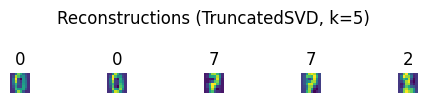


Reconstruction with k = 10


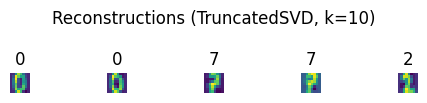


Reconstruction with k = 20


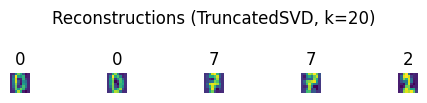


Reconstruction with k = 40


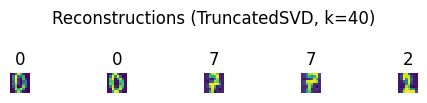

In [6]:
# 4. Reconstruction demo using TruncatedSVD (scikit-learn)
# TruncatedSVD provides a transform/inverse_transform pipeline for low-rank reconstruction
sample_idxs = [0, 1, 2, 10, 50]
ks = [1, 5, 10, 20, 40]

for k in ks:
    print('\nReconstruction with k =', k)
    tsvd = TruncatedSVD(n_components=k, random_state=42)
    tsvd.fit(Xc)
    X_proj = tsvd.transform(Xc)            # (n_samples, k)
    X_recon = tsvd.inverse_transform(X_proj) + X_mean
    recon = X_recon[sample_idxs]
    plot_digits(recon, labels=y_train[sample_idxs], n_cols=len(sample_idxs),
                title=f'Reconstructions (TruncatedSVD, k={k})')


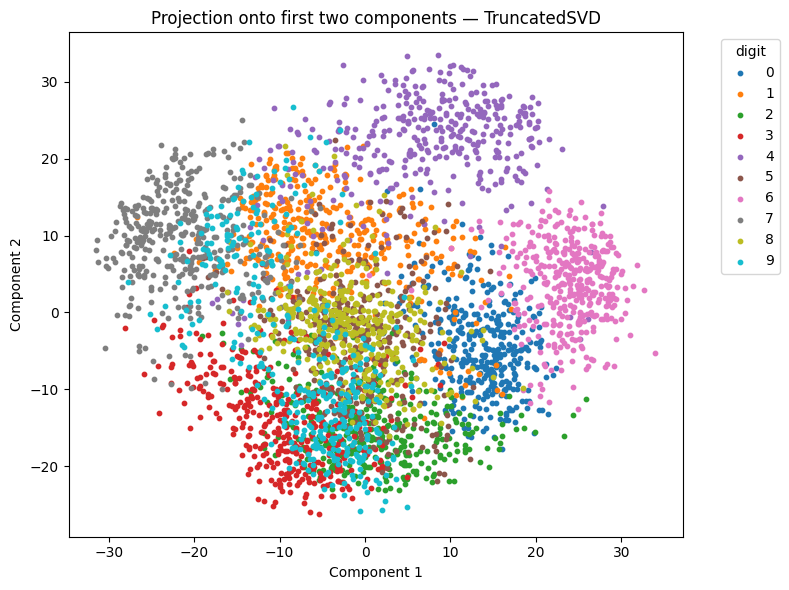

In [7]:
# 5. Projection onto first 2 components (using TruncatedSVD)
# We'll fit a 2-component TruncatedSVD and plot the transformed coordinates
tsvd2 = TruncatedSVD(n_components=2, random_state=42)
coords2 = tsvd2.fit_transform(Xc)  # shape (n_samples, 2)

plt.figure(figsize=(8,6))
for digit in np.unique(y_train):
    mask = (y_train == digit)
    plt.scatter(coords2[mask,0], coords2[mask,1], label=str(digit), s=10)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Projection onto first two components — TruncatedSVD')
plt.legend(title='digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
